# <center> 👯 LangGraph и Мультиагенты  </center>
### <center> 🎮 Сами управляем поведением "агента" 🕵️‍♂️ </center>

### Оглавление ноутбука
<img src='../images/LG.png' align="right" width="500" height="428" >
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#p1">🕸 Что за LangGraph ещё такой?</a></li>
<li><a href="#p2">🧩 Составные части LangGraph.</a></li><ul type="square">
<li><a href="#p2.1">ReAct Agent - в LangGraph!🚀</a></li></ul>
<li><a href="#p3">Добавляем память 🧠</a></li>
<li><a href="#p4">Мультиагенты - в LangGraph!🚀</a></li>
<li><a href="#p5">🧔 Скажи-ка дядя! Human in the loop (HIL)</a></li>
<li><a href="#p6"> 🪢 Кастомный мульти-агент</a></li>
<li><a href="#p9">🥁 Выводы и заключения ✅ </a></li>


    
</ul></font></p>

#### 🧑‍🎓 В этом уроке разберёмся зачем ~~козе баян~~ использовать LangGraph для создания агентов. 🪗

# <center  id="p1"> 🕸 Что за LangGraph ещё такой? </center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
    
📖 `LangGraph` - это расширение `LangChain`, направленное на создание надежных и отслеживающих состояние многоакторных приложений с использованием LLM путем моделирования шагов в виде ребер и узлов в графе. [Документация LangGraph](https://langchain-ai.github.io/langgraph/)

#### Когда какой фрэймворк применять?

* Создавая агентов в `LangChain`, мы даём модели больше свободы в использовании инструментов, но получаем больше галлюцинаций и неконтролируемого поведения. Позволяет быстрее проверять гипотезы и писать меньше кода.
* `LangGraph` - даёт нам контроль над системой и больше подходит для production-ready решений.

In [32]:
!pip install langchain langchain-classic langchain-community google-search-results langchain-openai openai langchain-experimental langgraph langgraph-supervisor tavily-python -U -q

In [1]:
import os
from getpass import getpass
from pprint import pprint

In [ ]:
# # Если используете ключ от OpenAI, запустите эту ячейку
# from langchain_openai import ChatOpenAI

# # os.environ['OPENAI_API_KEY'] = "Введите ваш OpenAI API ключ"
# os.environ['OPENAI_API_KEY'] = getpass(prompt='Введите ваш OpenAI API ключ')

# # инициализируем языковую модель
# llm = ChatOpenAI(temperature=0.0)

In [2]:
# Если используете ключ из курса, запустите эту ячейку
from langchain_openai import ChatOpenAI

# course_api_key= "Введите ваш ключ, полученный в боте курса"
course_api_key = getpass(prompt="Введите ваш ключ, полученный в боте курса:")

# инициализируем языковую модель
llm = ChatOpenAI(api_key=course_api_key, model='gpt-4o-mini', 
                 base_url="https://aleron-llm.neuraldeep.tech/")

Введите ваш ключ, полученный в боте курса: ········


# <center  id="p1"> 🧩 Составные части LangGraph. </center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<img src='../images/nodeedge.png' align="top">
    
    
#### Основные сущности `LangGraph`

По своей сути, `LangGraph` использует структуру ориентированного графа для определения потока выполнения вашего приложения:

* **Узлы** (`Nodes`) - представляют отдельные этапы обработки (например, вызов LLM, использование инструмента или принятие решения). Узлами могут быть отдельные агенты, Runnables, Python-функции, другие примитивы.
* **Ребра** (`Edges`) - определяют возможные переходы между этапами.
* **Состояние** (`State`) - ключевой компонент, котрый определяется пользователем, поддерживается и передается между узлами во время выполнения. При принятии решения о том, какой узел будет выбран следующим, мы обращаем внимание на текущее состояние.

Пока может быть не очень понятно, давайте рассмотрим пример:

In [3]:
from typing_extensions import TypedDict, Literal


# Определяем схему состояния - датакласс, в котором будет лежать список letters
class State(TypedDict):
    letters: list[str]

In [4]:
# Определяем узлы (Nodes) - обычные Python-функции
# Каждый узел печатает строку и добавляет в список либо букву А, либо В
def node_a(state: State) -> dict:
    print(f'Узел A видит состояние: {state["letters"]}')
    return {"letters": state["letters"] + ["A"]}

def node_b(state: State) -> dict:
    print(f'Узел B видит состояние: {state["letters"]}')
    return {"letters": state["letters"] + ["B"]}

In [5]:
from langgraph.graph import StateGraph

# Создаем граф
graph_builder = StateGraph(State)

# Добавляем узлы методом add_node, в которые подаём произвольное имя узла и название функции
graph_builder.add_node("a", node_a) 
graph_builder.add_node("b", node_b)

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
    
Служебные узлы `START` и `END` присутствуют в каждом графе.

In [6]:
from langgraph.graph import START, END


# Определяем функцию для условного перехода
def route(state: State) -> Literal["b", END]:
    if len(state["letters"]) < 5:
        return "b"
    else:
        return END

# Добавляем ребра (Edges) методом add_edge или add_conditional_edges
graph_builder.add_edge(START, "a")               # Начинаем с узла "a"
graph_builder.add_conditional_edges("a", route) # После "a" идем либо в "b", либо завершаем
graph_builder.add_edge("b", "a")                 # После "b" возвращаемся в "a"

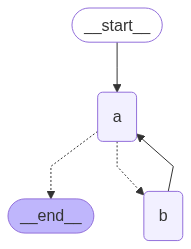

In [7]:
from IPython.display import Image, display

# Компилируем граф перед использованием
graph = graph_builder.compile()

# Также можем посмотреть схему получившегося графа
display(Image(graph.get_graph().draw_mermaid_png()))

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Пунктиром обозначены условные рёбра, сплошной линией обычные рёбра.

In [8]:
# Запускаем граф с начальным состоянием [], так как это тоже Runnable, то invoke
result = graph.invoke({"letters": []})

print("Итоговое состояние:", result)

Узел A видит состояние: []
Узел B видит состояние: ['A']
Узел A видит состояние: ['A', 'B']
Узел B видит состояние: ['A', 'B', 'A']
Узел A видит состояние: ['A', 'B', 'A', 'B']
Итоговое состояние: {'letters': ['A', 'B', 'A', 'B', 'A']}


<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
* Видим, что после запуска граф начинает проходить по заданному нами пути из рёбер
* При этом меняется сосотояние графа, которое отслеживается для определения следуещего шага
* При достижении заданного состояния (длина списка 5), выбирается закончить работу

# <center  id="p2"> `ReAct` `Agent` - в LangGraph!🚀</center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    

В модуле `LangGraph.prebuilt` есть несколько готовых реализаций агентов, в частности, уже знакомый нам `ReAct` агент.

Давайте посмотрим на его работу:

In [9]:
# Возьмём знакомый инструмент веб-поиска
from langchain_classic.agents import load_tools

# Добавляем ключ в переменную среды
os.environ["SERPAPI_API_KEY"] = getpass(prompt="Введите ваш ключ SerpApi:")

tools = load_tools(["serpapi"], llm=llm)

Введите ваш ключ SerpApi: ········


In [11]:
# импортируем и создаём react агент
from langgraph.prebuilt import create_react_agent


agent_executor = create_react_agent(llm, tools)

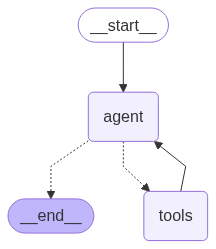

In [27]:
# Можем посмотреть на граф react агента
display(Image(agent_executor.get_graph().draw_mermaid_png()))

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Видим, что граф `ReAct` агента представляет из себя:
* узел `agent` с двумя условными рёбрами
* агент по условию решает переходить в узел `tools` или завершить работу, другими словами агент решает нужно ли ему ещё воспользоваться какими-либо инструментами или можно завершить работу.

In [17]:
# запустим агента
agent_executor.invoke({'messages':'Какая температура в Сочи?'})['messages'][-1].content

'Температура в Сочи сейчас составляет 62 градуса Фаренгейта (примерно 16 градусов Цельсия). Погода ясная, вероятность осадков 0%, влажность 77%, скорость ветра 2 миль в час.'

## <center> Добавляем память 🧠 </center>

In [27]:
# сначала выбираем тип памяти
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver() 

In [28]:
# затем добавляем её в параметр checkpointer
agent_executor = create_react_agent(llm, tools, checkpointer=memory)

# в лэнгчейн указывали session_id, здесь thread_id
config = {"configurable": {"thread_id": "user123"}}
response = agent_executor.invoke({"messages": "Какая температура в Сочи?"}, config)

for m in response['messages']:
    m.pretty_print() # с помощью данного метода можно выводить messages в читаемом формате

================================ Human Message =================================

Какая температура в Сочи?
================================== Ai Message ==================================
Tool Calls:
  Search (call_Hk8q6yYsQEH10xlbOR1p97na)
 Call ID: call_Hk8q6yYsQEH10xlbOR1p97na
  Args:
    __arg1: температура в Сочи
================================= Tool Message =================================
Name: Search

{'type': 'weather_result', 'temperature': '62', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '77%', 'wind': '2 mph', 'location': 'Sochi, Russia', 'date': 'Friday 3:00 AM', 'weather': 'Clear'}
================================== Ai Message ==================================

Температура в Сочи составляет 62°F (примерно 16°C). Сейчас ясная погода, влажность 77%, скорость ветра 2 миль в час.


In [29]:
response = agent_executor.invoke({'messages':'А какая температура воды?'}, config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Какая температура в Сочи?
================================== Ai Message ==================================
Tool Calls:
  Search (call_Hk8q6yYsQEH10xlbOR1p97na)
 Call ID: call_Hk8q6yYsQEH10xlbOR1p97na
  Args:
    __arg1: температура в Сочи
================================= Tool Message =================================
Name: Search

{'type': 'weather_result', 'temperature': '62', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '77%', 'wind': '2 mph', 'location': 'Sochi, Russia', 'date': 'Friday 3:00 AM', 'weather': 'Clear'}
================================== Ai Message ==================================

Температура в Сочи составляет 62°F (примерно 16°C). Сейчас ясная погода, влажность 77%, скорость ветра 2 миль в час.
================================ Human Message =================================

А какая температура воды?
================================== Ai Message ===========================

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
По истории агент понял, что мы имеем ввиду Сочи.

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<img src='../images/hooks.png' align="right" width="300" height="328" >
<br>

Также к `ReAct` агенту можно добавить:
* `pre_model_hook` - функция, которая вызывается перед вызовом модели. Ее можно использовать для сжатия сообщений или выполнения других задач предварительной обработки.
* `post_model_hook` - функция, которая вызывается после вызова модели.
* `response_format` - cтруктура данных, используемая для ограничения типа конечного результата, например, базовая модель pydantic.

Для этого в есть специальные параметры:
```python
agent = create_react_agent(
    model,
    tools=[tool],
    pre_model_hook=pre_model_hook,
    post_model_hook=post_model_hook,
    response_format=ResponseFormat,
)
```

# <center  id="p2"> Мультиагенты - в LangGraph!🚀</center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

### А зачем нам мульти-агенты? 🤔

По мере разработки агентных систем они могут со временем усложняться, что затрудняет управление ими и их масштабирование. Например, вы можете столкнуться со следующими проблемами:
* агент имеет в своем распоряжении слишком много инструментов и принимает неверные решения о том, какой инструмент вызывать следующим
* контекст становится слишком сложным для отслеживания одним агентом
* возникает необходимость в нескольких областях специализации в системе (например, планировщик, исследователь, специалист по математике и т.д.).
  
Чтобы решить эти проблемы, вы можете разбить свое приложение на несколько небольших независимых агентов и объединить их в мультиагентную систему.

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<img src='../images/architectures.png' align="right" width="500" height="428" >
<br>
Существует несколько способов подключения агентов в мультиагентной системе:

* **Сеть** (`Network`) - каждый агент может взаимодействовать с любым другим агентом. Любой агент может решить, какой агент вызывать следующим.
* **Супервизор** (`Supervisor`) - каждый агент взаимодействует с одним агентом-супервизором. Агент-супервизор принимает решения о том, какой агент следует вызвать следующим.
* **Супервизор (вызов инструмента)** - это частный случай архитектуры супервизора. Отдельные агенты могут быть представлены в виде инструментов. В этом случае агент-супервизор использует вызывающий инструмент LLM, чтобы решить, какой из инструментов агента вызывать, а также какие аргументы передавать этим агентам.
* **Иерархическая** (`Hierarchical`) - позволяет создать многоагентную систему с супервизором супервизоров. Это обобщение архитектуры супервизора и позволяет создавать более сложные потоки управления.
* **Настраиваемый многоагентный рабочий процесс** - каждый агент взаимодействует только с подмножеством агентов. Части потока детерминированы, и только некоторые агенты могут решать, какие другие агенты вызывать следующими.

В `LangGraph` есть готовыe классы и методы для сборки агентов в мульти-агентные структуры.

Давайте посмотрим на примере структуры `Supervisor`:

In [ ]:
# Инструменты агентов (упрощённые)
def get_weather(city: str) -> str:
    '''Возвращает погоду в городе'''
    return f"Погода в городе {city} всегда солнечная."

def get_time(city: str) -> str:
    '''Возвращает текущее время в городе'''
    return f"Время в городе {city} сейчас 12:00."

# Создаем агентов с разными инструментами и ролями
weather_agent = create_react_agent(
    llm,
    tools=[get_weather],
    prompt="Ты помощник по погоде. Отвечай на вопросы о погоде.",
    name="weather_agent"
)

time_agent = create_react_agent(
    model=llm,
    tools=[get_time],
    prompt="Ты помощник по времени. Отвечай на вопросы о времени.",
    name="time_agent"
)

In [ ]:
from langgraph_supervisor import create_supervisor

# Создаем супервизора, который распределяет задачи между агентами
supervisor = create_supervisor(
    agents=[weather_agent, time_agent],
    model=llm,
    prompt=(
        "Ты управляешь двумя помощниками: weather_agent и time_agent. "
        "Если вопрос про погоду, направь к weather_agent. "
        "Если про время — к time_agent."
    )
).compile()

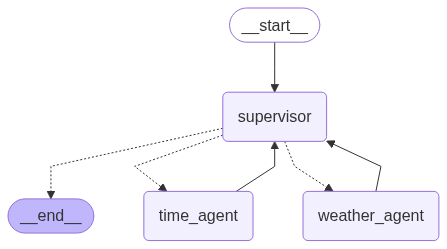

In [35]:
# Посмотрим на получившийся граф
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [41]:
# Запускаем мультиагентную систему с запросом пользователя
for chunk in supervisor.stream(
    {"messages": "Какая погода в Москве и который час?"}
):
    pprint(chunk)

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


{'supervisor': {'messages': [HumanMessage(content='Какая погода в Москве и который час?', additional_kwargs={}, response_metadata={}, id='094aa5db-90c9-47b5-8f27-81f74dd8a94e'),
                             AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xer4H0jIj5lfq9cyEhR9TnK4', 'function': {'arguments': '{}', 'name': 'transfer_to_weather_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 104, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bn2MczusznF9nlh3IIWeZjLVyMd9q', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--b5971a67-bf53-4f07-9873-41d63da2261d-0', tool_

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


{'supervisor': {'messages': [HumanMessage(content='Какая погода в Москве и который час?', additional_kwargs={}, response_metadata={}, id='094aa5db-90c9-47b5-8f27-81f74dd8a94e'),
                             AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xer4H0jIj5lfq9cyEhR9TnK4', 'function': {'arguments': '{}', 'name': 'transfer_to_weather_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 104, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bn2MczusznF9nlh3IIWeZjLVyMd9q', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--b5971a67-bf53-4f07-9873-41d63da2261d-0', tool_

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Видим процесс общения между агентами и супервизором.

# <center  id="p2"> 🧔 Скажи-ка дядя! Human in the loop (HIL) </center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<img src='../images/hil.png' align="top">

В процессе работы агентов или других приложений с LLM, часто встречается ситуация, когда нужна валидация, корректировка или дополнительный контекст от пользователя.

**Human-in-the-loop (HIL)** - часто встречаемое название концепции, которая подразумевает участие человека в процессе работы сервиса.

В `LangGraph` предусмотрены специальные классы и методы для реализации этой концепции, чаще всего это создание отдельного узла, в котором происходит прерывание (`interrupt`) исполнения и взаимодействие с пользователем. 

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Добавим в предыдущий пример с супервизором HIL!

In [ ]:
# Определяем можель состояния для супервизора с human-in-the-loop
class State(TypedDict):
    messages: list
    human_feedback: str

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Импортируем `interrupt`, чтобы добавить в узел прерывание, и `Command` - класс "отдающий команду" куда дальше двигаться.

In [80]:
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

# Пишем узел HIL
def human_in_the_loop_node(state: State) -> Command[str]:
    if state['human_feedback']:
        return Command(goto=END)
        
    # Получаем итоговый ответ супервизора
    last_response = ""
    for msg in reversed(state["messages"]):
        if getattr(msg, "type", None) == "ai":
            last_response = getattr(msg, "content", "")
            break
    # Делаем прерывание и ждём пользовательский ввод
    feedback = interrupt(f"Проверьте ответ агента: '{last_response}'. Введите правки или подтвердите:")

    # Подтверждать будем словом ОК
    if feedback and feedback.strip().lower() not in ('ok', 'ок'):
        updated_message = {"role": "user", "content": feedback}
        # Заменяем последнее сообщение пользователя на новое с правками
        new_messages = [m for m in state["messages"] if getattr(msg, "type", None) != "human"] + [updated_message]
        return Command(goto="supervisor", update={"messages": new_messages, "human_feedback": feedback})
    else:
        return Command(goto=END, update={"human_feedback": feedback})

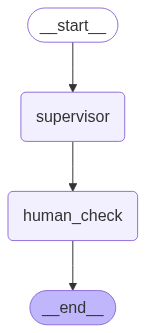

In [84]:
# Строим граф с human-in-the-loop после супервизора
builder = StateGraph(State)

# Добавляем узлы
builder.add_node("supervisor", supervisor)
builder.add_node("human_check", human_in_the_loop_node)

# Добавляем ребра
builder.add_edge(START, "supervisor")
builder.add_edge("supervisor", "human_check")
builder.add_edge("human_check", END)

# Настраиваем сохранение состояния для HIL
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Посмотрим на получившийся граф
display(Image(graph.get_graph().draw_mermaid_png()))

In [87]:
# Запускаем граф с запросом пользователя
initial_state = {
    "messages": [{"role": "user", "content": "Какая погода в Москве и который час?"}],
    "human_feedback": ""
}
config = {"configurable": {"thread_id": "user123"}}

# Запуск с ожиданием human-in-the-loop
for event in graph.stream(initial_state, config=config):
    pprint(event)
    if "__interrupt__" in event:
        user_input = input("Введите правки или подтвердите ответ: ")
        # При помощи Command передаём ответ пользователя в interrupt
        for cont_event in graph.stream(Command(resume=user_input), config=config):
            pprint(cont_event)

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


{'supervisor': {'messages': [HumanMessage(content='Какая погода в Москве и который час?', additional_kwargs={}, response_metadata={}, id='a5e457dd-9ce5-47c0-b3f6-f14355279494'),
                             AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_A1SHHlsXq06rEysdUOeViesB', 'function': {'arguments': '{}', 'name': 'transfer_to_weather_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 104, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnUf0xuNqqPu0glDvG0ENsKlzxZ4G', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--7a20e82c-d170-4b9e-a545-41366b5d3b6f-0', tool_

Введите правки или подтвердите ответ:  Я хотел про Воронеж


{'human_check': {'human_feedback': 'Я хотел про Воронеж',
                 'messages': [HumanMessage(content='Какая погода в Москве и который час?', additional_kwargs={}, response_metadata={}, id='a5e457dd-9ce5-47c0-b3f6-f14355279494'),
                              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_A1SHHlsXq06rEysdUOeViesB', 'function': {'arguments': '{}', 'name': 'transfer_to_weather_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 104, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnUf0xuNqqPu0glDvG0ENsKlzxZ4G', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervis

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task human_check with path ('__pregel_pull', 'human_check') wrote to unknown channel branch:to:__end__, ignoring it.


{'supervisor': {'messages': [HumanMessage(content='Какая погода в Москве и который час?', additional_kwargs={}, response_metadata={}, id='a5e457dd-9ce5-47c0-b3f6-f14355279494'),
                             AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_A1SHHlsXq06rEysdUOeViesB', 'function': {'arguments': '{}', 'name': 'transfer_to_weather_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 104, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnUf0xuNqqPu0glDvG0ENsKlzxZ4G', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--7a20e82c-d170-4b9e-a545-41366b5d3b6f-0', tool_

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Мы смогли как откорректировать, так и подтвердить ответ модели!

Таким образом, мы могли бы подтвердить, например, бронировать найденный отель или нет.

Самые частые паттерны использования HIL в агентных системах:
- валидация ответа модели (отказать или продолжить)
- проверка и редактирование текущего состояния (`State`)
- вылидация правильности выбора инструментов

Также HIL можно добавить к любому инструменту, подробнее читатйте в [документации](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#add-interrupts-to-any-tool)

# <center> 🪢 Кастомный мульти-агент </center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Давайте попробуем создать целую редакцию, для написания статей!

Для реализации этого агента будем использовать ещё один популярный инструмент веб-поиска - `Tavily Search`. Для использования сервиса, перейдите по [ссылке](https://www.tavily.com), зарегистрируйтесь и создайте себе API-ключ.

In [132]:
os.environ['TAVILY_API_KEY'] = getpass(prompt="Введите ваш Tavily API-ключ: ")

Введите ваш Tavily API-ключ:  ········


In [135]:
from tavily import TavilyClient
from pydantic import BaseModel
from typing import TypedDict, List

# Создадим модель со списком для запросов инструмента - поиск, для structured output
class Queries(BaseModel):
    queries: List[str]

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [149]:
# инициализируем память
memory = MemorySaver()

# Создаём датакласс, для хранения состояния системы (State)
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [142]:
# Напишем промпты для каждой из ролей
# Промпты (на русском, можно заменить на английский при необходимости)
PLAN_PROMPT = """Ты — писатель-эксперт. Твоя задача — составить план статьи по теме пользователя.
Опиши структуру статьи и дай заметки или инструкции для разделов."""

WRITER_PROMPT = """Ты — помощник по написанию статей.
Напиши наилучшую статью на основе запроса пользователя и плана.
Если пользователь даёт критику, исправь отчёт с учётом замечаний.
Используй всю доступную информацию: 
------ 
{content}"""

REFLECTION_PROMPT = """Ты — критик, оценивающий статью.
Сформулируй критику и рекомендации по улучшению: длина, глубина, стиль и т.д."""

RESEARCH_PLAN_PROMPT = """Ты — исследователь. Составь список из максимум 3 поисковых запросов,
которые помогут собрать необходимую информацию для статьи."""

RESEARCH_CRITIQUE_PROMPT = """Ты — исследователь. Составь список из максимум 3 поисковых запросов,
которые помогут собрать информацию для доработки статьи согласно критике."""

In [153]:
# Создаём отдельных агентов - узлы будущего графа
from langchain_core.messages import SystemMessage, HumanMessage

# агент-планировщик - пишет план будущей статьи
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = llm.invoke(messages)
    return {"plan": response.content}

# агент-исследователь - создаёт список из 3-х самых релевантных запросов по теме
# используем structured output, чтобы получить список запросов
# затем эти запросы подаются в поисковик и собираются в State по ключу content
def research_plan_node(state: AgentState):
    queries = llm.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

# агент-писатель, который по найденному контенту, пишет статью по плану и тематике.
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = llm.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }

# агент-критик (редактор) - находит недостатки и выдаёт рекомендации
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = llm.invoke(messages)
    return {"critique": response.content}

# агент-исследователь, который уточняет запросы и помогает устранить найденные недостатки
# для этого обращается к поисковику и обогащает content
def research_critique_node(state: AgentState):
    queries = llm.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

# функция, проверяющая достигла ли система лимита по ревью статьи
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

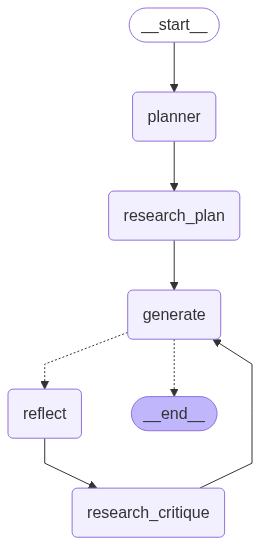

In [154]:
# Строим граф
builder = StateGraph(AgentState)

# Добавляем узлы (всех наших агентов)
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

# указываем агента, с которого следует стартовать
builder.set_entry_point("planner")

# Добавляем conditional edge
# оно решает, идти ещё на одну итерацию цикла или заканчивать
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

# Выстраиваем последовательность работы агентов (agent workflow)
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Компилируем граф
graph = builder.compile(checkpointer=memory)

# Визуализируем
display(Image(graph.get_graph().draw_mermaid_png()))

In [161]:
# Запускаем нашу редакцию
config = {"configurable": {"thread_id": "user1"}}
for s in graph.stream({
    'task': "Напиши статью о возможных сценариях применения мультиагентных систем на базе LLM",
    "max_revisions": 2,
    "revision_number": 1
}, config):
    print(s)
    # сохраним итоговую статью в переменную (так же можно сохранить план, критику и пр.)
    if "generate" in s:
        final_draft = s["generate"]["draft"]

{'planner': {'plan': '### Статья: Возможные сценарии применения мультиагентных систем на базе LLM\n\n#### Структура статьи\n\n1. **Введение**\n   - Определение мультиагентных систем (МАС).\n   - Краткий обзор LLM (Large Language Models) и их возможностей.\n   - Причины сочетания МАС и LLM: какие преимущества они могут дать в различных областях.\n\n   **Заметки**: В этом разделе следует установить контекст для читателя, объяснить основные термины и дать представление о современном состоянии технологий.\n\n2. **Основные компоненты мультиагентных систем**\n   - Агент и его характеристики.\n   - Коммуникация между агентами.\n   - Принятие решений и координация в мультиагентной среде.\n\n   **Заметки**: Важно подчеркнуть, что МАС состоят из автономных агентов, способных взаимодействовать друг с другом. Опишите, как LLM могут улучшить эти аспекты.\n\n3. **Сценарий 1: Обратная связь и поддержка в обучении**\n   - Применение в образовательных системах (наставники-агенты).\n   - Индивидуализиро

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Видим, как агенты по-очереди выполняют задачи, чётко по нашему графу, сохраняя промежуточное состояние в `state`.

**В качестве домашнего задания:** Встройте в эту систему HIL, чтобы человек говорил `ок` или просил внести правки.

In [164]:
# Итоговая статья
print(final_draft)

# Возможные сценарии применения мультиагентных систем на базе LLM

## 1. Введение

Мультиагентные системы (МАС) представляют собой сложные комплексы, состоящие из нескольких автономных агентов, которые взаимодействуют друг с другом и решают общие задачи. Эти системы находят применение в различных областях, включая робототехнику, транспорт, здравоохранение и образование. С другой стороны, модели больших языков (LLM) — такие как GPT-3 и другие современные языковые модели — обладают мощными возможностями обработки и генерации текста, что позволяет им эффективно взаимодействовать с пользователями и анализировать большие объемы информации. 

Комбинирование МАС и LLM открывает новые горизонты для автоматизации, улучшает взаимодействие между агентами и увеличивает их способность адаптироваться к новым требованиям. В этой статье мы рассмотрим несколько сценариев применения мультиагентных систем на базе LLM и проанализируем их преимущества и вызовы.

## 2. Основные компоненты мультиагентных сис

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Неплохо получилось, но есть к чему стремиться!

# <center id="p9"> 🥁 Выводы и заключения ✅</center>


<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

В этом уроке изучили, расширение `LangChain` - фрэймворк `LangGraph`, который позволяет:
* Четко задавать и контролировать поведение агентов, мульти-агентов и других многоакторных систем
* Создавать условные и циклические переходы между узлами
* Добавлять человека, как отдельного актора (узел графа)
* Отслеживать состояние всей системы и на основе этого принимать решения

Этот инструмент больше подходит для production-ready решений, так как делает результаты работы более предсказуемыми и контролируемыми.